# Pyem prelim

### Check basic functionality of the [pyem](https://github.com/asarnow/pyem) package
### Important: this requires a local copy of the pyem repository and access to the `project` function

Messy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from project import project as project_pyem
from pyem import star
from pyem import vop
from numpy.fft import fftshift
from pyfftw.builders import irfft2

In [3]:
import numpy as np
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=6,6

from simplecryoem.utils import *
from simplecryoem.projection import project_spatial, project, rotate_z0
from simplecryoem.interpolate import *

In [4]:
# Arguments for project:
# p : dataframe of star file : df = star.parse_star(args.input, keep_index=False); star.augment_star_ucsf(df);
#     Here, input is the STAR file with particle metadata

### The volume

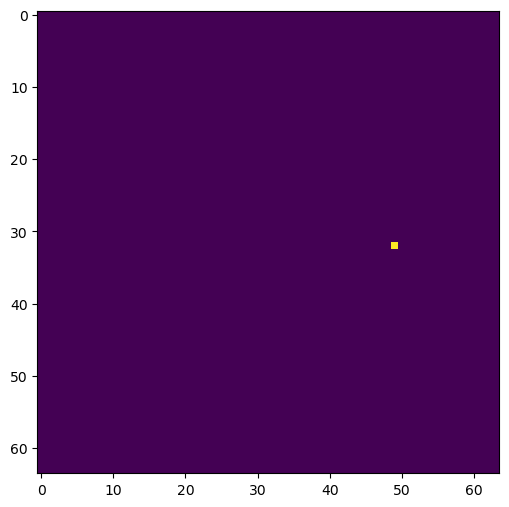

In [5]:
nx = 64
dx = 0.2

v = np.zeros([nx,nx,nx])
v[32,32,49] = 1

mip_x(v)

In [6]:
# f3d : Fourier volume (centred, Nyquist-limited, zero-padded (pfac=2), normalized (normfft=1) interpolation-ready 3D Fourier transform)

pfac = 2
f3d = vop.vol_ft(v, pfac=pfac, threads=1)

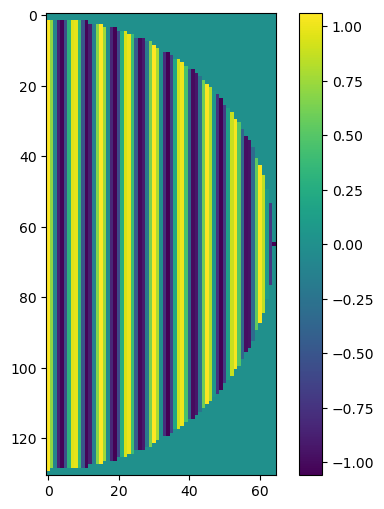

In [7]:
plt.imshow(np.real(f3d[f3d.shape[0]//2,:,:])); plt.colorbar()

### Parameters from the star file
https://relion.readthedocs.io/en/release-3.1/Reference/Conventions.html?highlight=star#star-format

In [8]:
df = star.parse_star("data/pyem.star", keep_index = False)

In [9]:
dfiter = df.iterrows()
i, p = next(dfiter)
#i, p = next(dfiter)

#p["rlnVoltage"] = 0
#p["rlnSphericalAberration"]
p[star.Relion.ORIGINX] = 0
p[star.Relion.ORIGINY] = 0

# These don't seem to make any difference here. These replaced rlnOriginX and rlnOriginY (pixels) in Relion 3.1
p[star.Relion.ORIGINXANGST] = 0
p[star.Relion.ORIGINYANGST] = 0

p[star.Relion.ANGLEROT] = 90  # Around the z axis (first axis)
p[star.Relion.ANGLETILT] = 0 # Around the new y axis 
p[star.Relion.ANGLEPSI] = 0 # Arond the new z axis


p["rlnSphericalAberration"] = 0
p["rlnAmplitudeContrast"] = 0

p[star.Relion.DEFOCUSU] = 0
p[star.Relion.DEFOCUSV] = 0
p[star.Relion.DEFOCUSANGLE] = 0

pzero = p.copy()
pzero

index                                                                             0
rlnVoltage                                                                    200.0
rlnSphericalAberration                                                            0
rlnAmplitudeContrast                                                              0
rlnOpticsGroup                                                                    1
rlnOpticsGroupName                                                     opticsGroup1
rlnImagePixelSize                                                              3.54
rlnImageSize                                                                     64
rlnImageDimensionality                                                            2
rlnImageName                                                        000001@pyem.mrc
rlnImageOriginalName              000233@Extract/job007/Movies/20170629_00021_fr...
rlnMicrographName                 MotionCorr/job002/Movies/20170629_00021_fr

In [10]:
#pfac = 2

size = (f3d.shape[0] - 3) // pfac
#size = f3d.shape[0]

sz = (f3d.shape[0] - 3) // pfac
#sz = size
apix = star.calculate_apix(df) * np.double(size) / sz
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)

f2d = project_pyem(f3d, p, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)


ift = irfft2(f2d.copy(), threads=1, planner_effort="FFTW_ESTIMATE", auto_align_input=True, auto_contiguous=True)
proj = fftshift(ift(f2d.copy(), np.zeros(ift.output_shape, dtype=ift.output_dtype)))

#plt.imshow(proj); plt.colorbar()

0.8300213
-0.07735421
(64, 33)


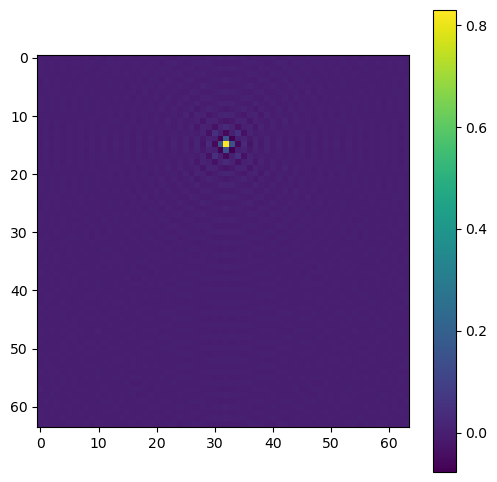

In [11]:
plt.imshow(proj); plt.colorbar()
#plt.imshow(np.log(np.abs(proj)+1e-15)); plt.colorbar()

print(np.max(proj))
print(np.min(proj))
print(f2d.shape)

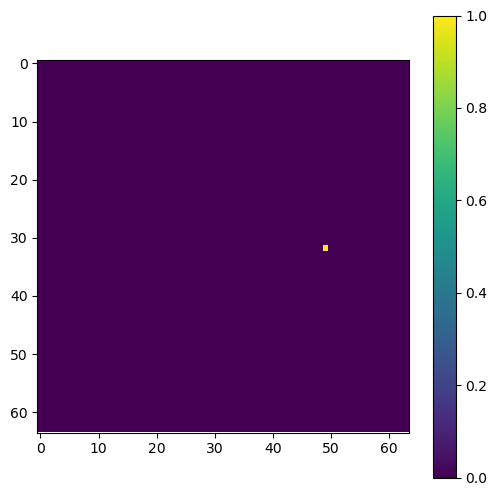

In [12]:
mip_x(v); plt.colorbar()

## Fourier point source

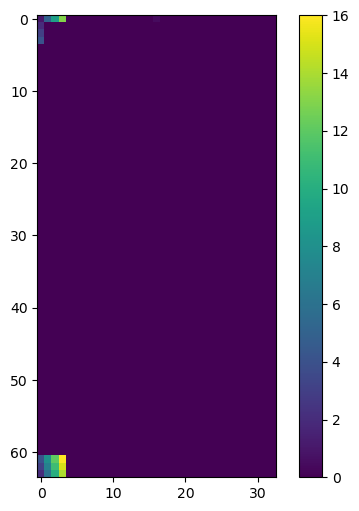

In [13]:
vf = np.zeros([67,67,33])
vf[33, 33, 0] = 0.5
vf[33, 49, 0] = 0.5

vf[33, 33:37, 0:4] = np.arange(1,17).reshape(4,4)

#size = 64
pfac = 1

size = (vf.shape[0] - 3) // pfac

sz = (vf.shape[0] - 3) // pfac
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)

p1 = pzero.copy()
p1[star.Relion.ANGLEROT] = 90
p1[star.Relion.ANGLETILT] = 0
p1[star.Relion.ANGLEPSI] = 0

p1[star.Relion.ORIGINX] = 0
p1[star.Relion.ORIGINY] = 0

f2d = project_pyem(vf, p1, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)
plt.imshow(np.real(f2d)); plt.colorbar()

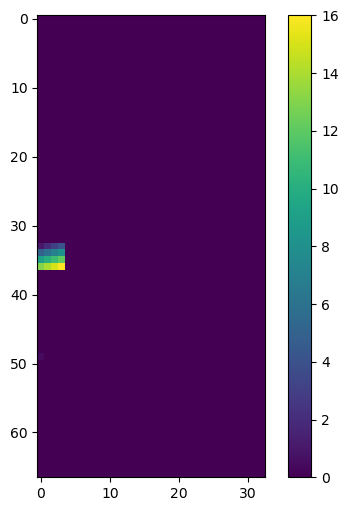

In [14]:
mip_x(np.abs(vf)); plt.colorbar()

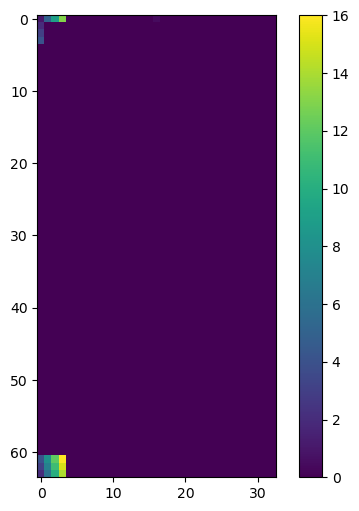

In [15]:
plt.imshow(np.real(f2d)); plt.colorbar()

In [16]:
vf = np.zeros([19,19,9], dtype=np.complex128)
vf[9, 13, 0] = 1 + 1j

size = 16
pfac = 1

size = (vf.shape[0] - 3) // pfac

sz = (vf.shape[0] - 3) // pfac
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)

p1 = pzero.copy()
p1[star.Relion.ANGLEROT] = 0

p1[star.Relion.ANGLETILT] = 0
p1[star.Relion.ANGLEPSI] = 0

p1[star.Relion.ORIGINX] = 0
p1[star.Relion.ORIGINY] = 0

f2d = project_pyem(vf, p1, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)


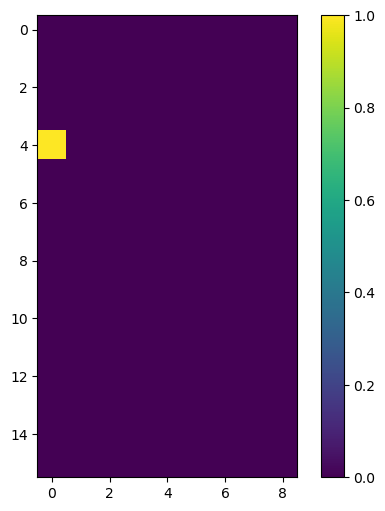

In [17]:
plt.imshow(np.real(f2d)); plt.colorbar()